# Supervised learning

This notebook will test supervised learning with only the variables available pre-welding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading of the train and test sets defined in 3-scaling
df_train = pd.read_csv("../data/train_normalised.csv")
df_test = pd.read_csv("../data/test_normalised.csv")


For supervised learning, we will only keep labelled data, which is what is done in the following part

In [2]:
cols_to_drop = ["PrimaryFerrite","Ferrite2ndPhase","AcicularFerrite","Martensite","FerriteCarbide",
                "HeatInput","InterpassTemp","UTS","Elongation","ReductionArea","CharpyTemp","CharpyImpact","Hardness","FATT50"]

target = "YieldStrength"

# Definition of X_train and y_train
X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_test  = df_test.drop(columns=[target])
y_test  = df_test[target]

# Drop columns that are not available pre-welding
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

# Masks for labelled data
mask_labelled   = y_train.notna()

X_train_labelled   = X_train.loc[mask_labelled].copy()
y_train_labelled   = y_train.loc[mask_labelled].copy()


We will here test 2 different supervised learning method : 
* **Random Forest Regressor**
* **Gradient Boosting Regressor**

We will evaluate their performance based on :
* **Graphs** : How close the predicted values of the YieldStrength are to the observed values of the YieldStrength; 
* **R²** : the closest to 1, the better the model, as it means that the model encapsulate the variance well
* **Mean Squared Error** : the smaller the better, as it will mean that great errors rarely exist
* **Mean Absolute Error** : the smaller the better, it shows how close the model predicts the Yield Strength

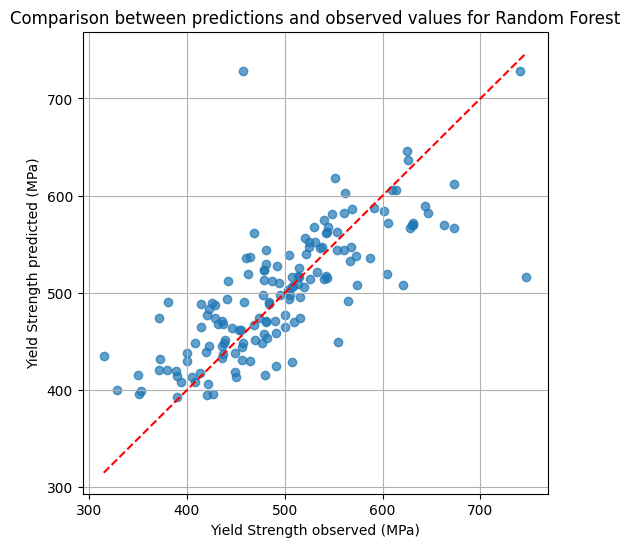

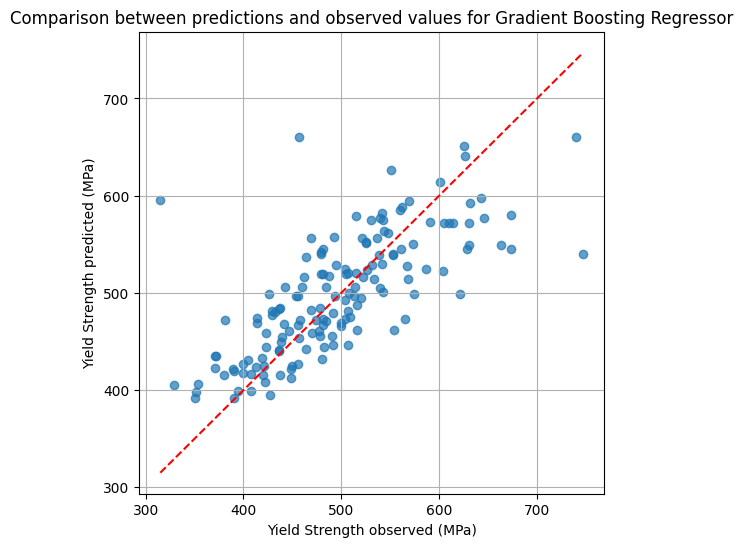

,MAE,MSE,R²
Random Forest,36.835026,51.958346,0.576191
Gradient Boosting Regressor,39.706417,54.841920,0.527844


In [3]:
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=300, 
        random_state=42
        ),
    "Gradient Boosting Regressor": HistGradientBoostingRegressor(
        learning_rate=0.1, 
        max_iter=300, 
        max_depth=6, 
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
        )
}

results = {}
for name, model in models.items():
    model.fit(X_train_labelled, y_train_labelled)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": rmse, "R²": r2}
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Yield Strength observed (MPa)")
    plt.ylabel("Yield Strength predicted (MPa)")
    plt.title(f"Comparison between predictions and observed values for {name}")
    plt.grid(True)
    plt.show()

pd.DataFrame(results).T.sort_values("R²", ascending=False)


We effectively lost some precision, as the post welding variables are very depicting of the quality of the weld.

Fine-tuning of the two models, to try and better the results :

Tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best CV R² for Random Forest: 0.6412

Tuning Gradient Boosting Regressor...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best CV R² for Random Forest: 0.6412

Tuning Gradient Boosting Regressor...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params for Gradient Boosting Regressor: {'learning_rate': 0.15, 'max_depth': 7, 'max_iter': 300, 'min_samples_leaf': 20}
Best CV R² for Gradient Boosting Regressor: 0.6467

Best params for Gradient Boosting Regressor: {'learning_rate': 0.15, 'max_depth': 7, 'max_iter': 300, 'min_samples_leaf': 20}
Best CV R² for Gradient Boosting Regressor: 0.6467



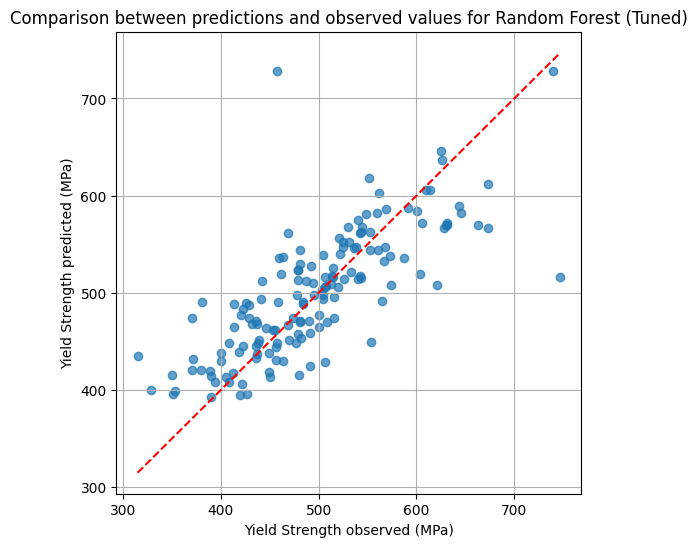

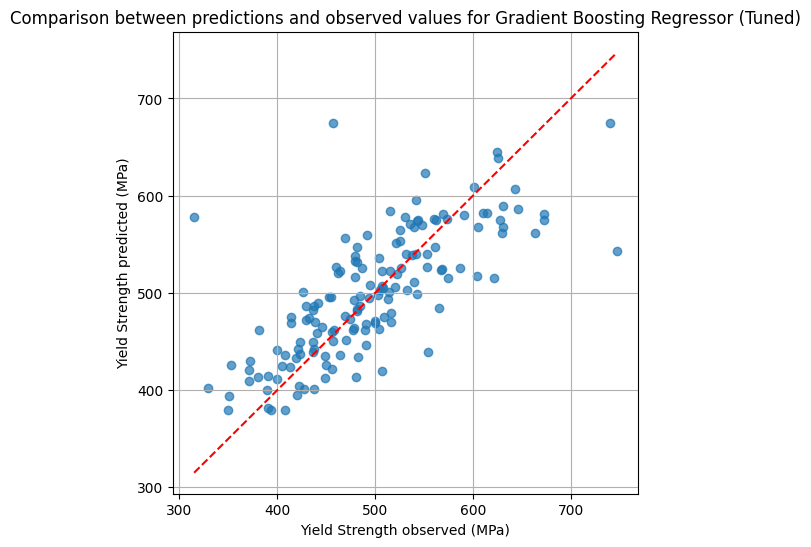

,MAE,MSE,R²
Random Forest,36.835026,51.958346,0.576191
Gradient Boosting Regressor,38.414189,53.310681,0.553842


In [4]:
from sklearn.model_selection import GridSearchCV

# Parameter grids for tuning
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting Regressor": {
        'learning_rate': [0.05, 0.1, 0.15],
        'max_iter': [300, 500, 700],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [10, 20, 30]
    }
}

# Tune models using 5-fold cross-validation
tuned_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='r2',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    grid_search.fit(X_train_labelled, y_train_labelled)
    tuned_models[name] = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV R² for {name}: {grid_search.best_score_:.4f}")
    print()

# Use tuned models for evaluation
models = tuned_models

results = {}
for name, model in models.items():
    model.fit(X_train_labelled, y_train_labelled)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": rmse, "R²": r2}
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Yield Strength observed (MPa)")
    plt.ylabel("Yield Strength predicted (MPa)")
    plt.title(f"Comparison between predictions and observed values for {name} (Tuned)")
    plt.grid(True)
    plt.show()

pd.DataFrame(results).T.sort_values("R²", ascending=False)

The results being somewhat similar, we'll choose the Random Forest predictor to be able to explain the feature importance.

Top 10 Feature Importances:
   Feature  Importance
13      Mn    0.169941
20      Nb    0.128842
15      Cr    0.124486
0        C    0.073004
6        W    0.052037
16      Mo    0.046519
17      Cu    0.034086
4        V    0.031641
3        P    0.031463
12      Sb    0.028206


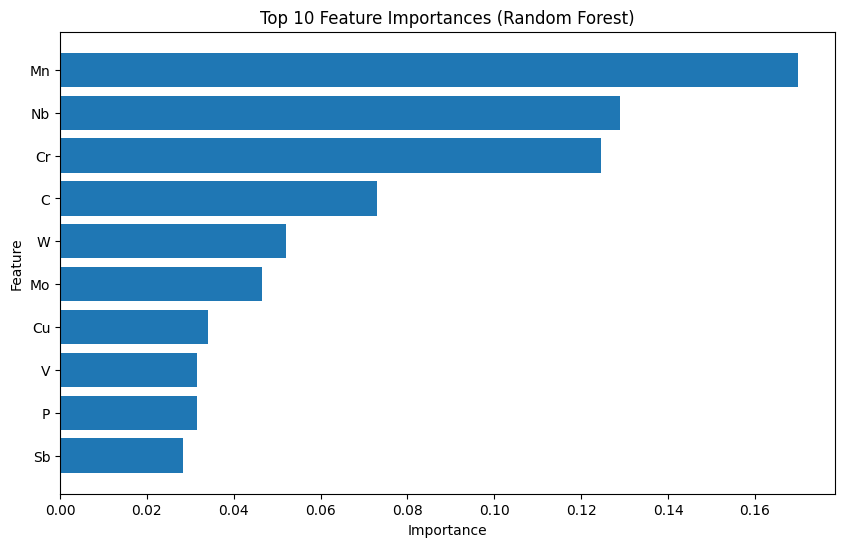

In [5]:
# Get feature importances from the Random Forest model
importances = models["Random Forest"].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Feature Importances:")
print(importance_df.head(10))

# Optional: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

We notice then that the chemical characteristics are the most important in determining the yield strength.